In [33]:
%matplotlib inline 
# inline plot만 하면 된다. 

# %matplotlib ipympl
# %matplotlib widget

# Backtrader: Quick Start

https://www.backtrader.com/docu/quickstart/quickstart/

## Basic Setup

In [64]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

from IPython.core.debugger import set_trace

import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

In [65]:
if __name__ == '__main__':
    cerebro = bt.Cerebro() # The Cerebro engine was instantiated
    print('Starting portfolio value: %.2f' % cerebro.broker.getvalue())
    
    cerebro.run() # The resulting cerebro instance was told to run (loop over data)
    print('Final portfolio value: %.2f' % cerebro.broker.getvalue())

Starting portfolio value: 10000.00
Final portfolio value: 10000.00


Although it doesn’t seem much, let’s point out something explicitly shown:

The Cerebro engine has created a broker instance in the background

The instance already has some cash to start with

This behind the scenes broker instantiation is a constant trait in the platform to simplify the life of the user. If no broker is set by the user, a default one is put in place.

And 10K monetary units is a usual value with some brokers to begin with.

## Setting the cash

In [66]:
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(1000000.0) # Set custom start cash. 
    print('Starting portfolio value: %.2f' % cerebro.broker.getvalue())
    
    cerebro.run() 
    print('Final portfolio value: %.2f' % cerebro.broker.getvalue())

Starting portfolio value: 1000000.00
Final portfolio value: 1000000.00


## Adding a Data Feed

Having cash is fun, but the purpose behind all this is to let an automated strategy multiply the cash without moving a finger by operating on an asset which we see as a Data Feed

In [67]:
# Add data directly from Yahoo finance using pandas-datareader

start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2020, 1, 10)

data = web.DataReader('AAPL', 'yahoo', start, end)
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-06,299.959991,292.750000,293.790009,299.799988,29596800.0,299.799988
2020-01-07,300.899994,297.480011,299.839996,298.390015,27218000.0,298.390015
2020-01-08,304.440002,297.160004,297.160004,303.190002,33019800.0,303.190002
2020-01-09,310.429993,306.200012,307.239990,309.630005,42527100.0,309.630005
2020-01-10,312.670013,308.250000,310.600006,310.329987,35161200.0,310.329987


In [68]:
# To OHLC + Adj CLose + V format

data = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-06,293.790009,299.959991,292.750000,299.799988,299.799988,29596800.0
2020-01-07,299.839996,300.899994,297.480011,298.390015,298.390015,27218000.0
2020-01-08,297.160004,304.440002,297.160004,303.190002,303.190002,33019800.0
2020-01-09,307.239990,310.429993,306.200012,309.630005,309.630005,42527100.0
2020-01-10,310.600006,312.670013,308.250000,310.329987,310.329987,35161200.0


In [69]:
data.to_csv('AAPL.csv', index=1)

In [70]:
os.getcwd()

'E:\\VSCodeProjects\\backtrader_tutorial'

In [71]:
datapath = os.path.join(os.getcwd(), './AAPL.csv')
datapath

'E:\\VSCodeProjects\\backtrader_tutorial\\./AAPL.csv'

In [72]:
os.path.isfile(datapath)

True

Yahoo Online sends the CSV data in date descending order, which is not the standard convention. The reversed=True prameter takes into account that the CSV data in the file has already been reversed and has the standard expected date ascending order.

In [73]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    
#     modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
#     datapath = os.path.join(modpath, '../../datas/orcl-1995-2014.txt')
    datapath = os.path.join(os.getcwd(), './AAPL.csv')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2015, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2020, 1, 10),
        reverse=False) # Yahoo data는 보통의 데이터와 반대이다. 

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00


## Our First Strategy

The cash is in the broker and the Data Feed is there. It seems like risky business is just around the corner.

Let’s put a Strategy into the equation and print the “Close” price of each day (bar).

DataSeries (the underlying class in Data Feeds) objects have aliases to access the well known OHLC (Open High Low Close) daily values. This should ease up the creation of our printing logic.

In [74]:
a = None
b = 2
c = a or b
c

2

In [75]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
#         print(self.datas) # [<backtrader.feeds.yahoo.YahooFinanceCSVData object at 0x0000022A079EA488>] 이러한 object가 들어있다. 
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close # close 데이터 모음. .datas[0].close[0] 이면 처음, [-1]이면 바로 이전 이런 식. 

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

Let’s explain some of the magic:

- Upon init being called the strategy already has a list of datas that are present in the platform. This is a standard Python list and datas can be accessed in the order they were inserted. The first data in the list `self.datas[0]` is the default data for trading operations and to keep all strategy elements synchronized (it’s the system clock)

- `self.dataclose = self.datas[0].close` keeps a reference to the close line. Only one level of indirection is later needed to access the close values.

- The strategy `next` method will be called on each bar of the system clock (`self.datas[0]`). This is true until other things come into play like indicators, which need some bars to start producing an output. More on that later.

In [76]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    datapath = os.path.join(os.getcwd(), './AAPL.csv')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2015, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2020, 1, 10),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2015-01-02, Close, 100.45
2015-01-05, Close, 97.62
2015-01-06, Close, 97.63
2015-01-07, Close, 99.00
2015-01-08, Close, 102.81
2015-01-09, Close, 102.92
2015-01-12, Close, 100.38
2015-01-13, Close, 101.27
2015-01-14, Close, 100.89
2015-01-15, Close, 98.15
2015-01-16, Close, 97.39
2015-01-20, Close, 99.89
2015-01-21, Close, 100.66
2015-01-22, Close, 103.28
2015-01-23, Close, 103.81
2015-01-26, Close, 103.92
2015-01-27, Close, 100.28
2015-01-28, Close, 105.95
2015-01-29, Close, 109.25
2015-01-30, Close, 107.65
2015-02-02, Close, 109.00
2015-02-03, Close, 109.02
2015-02-04, Close, 109.85
2015-02-05, Close, 110.64
2015-02-06, Close, 109.71
2015-02-09, Close, 110.43
2015-02-10, Close, 112.56
2015-02-11, Close, 115.19
2015-02-12, Close, 116.65
2015-02-13, Close, 117.22
2015-02-17, Close, 117.92
2015-02-18, Close, 118.74
2015-02-19, Close, 118.49
2015-02-20, Close, 119.46
2015-02-23, Close, 122.68
2015-02-24, Close, 121.92
2015-02-25, Close, 118.80
2015-02-

## Adding some Logic to the Strategy

Let’s try some crazy idea we had by looking at some charts

If the price has been falling 3 sessions in a row … BUY BUY BUY!!!

In [77]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        if self.dataclose[0] < self.dataclose[-1]:
            # current close less than previous close

            if self.dataclose[-1] < self.dataclose[-2]:
                # previous close less than the previous close

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.buy()

In [78]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    datapath = os.path.join(os.getcwd(), './AAPL.csv')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2015, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2020, 1, 10),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2015-01-02, Close, 100.45
2015-01-05, Close, 97.62
2015-01-05, BUY CREATE, 97.62
2015-01-06, Close, 97.63
2015-01-07, Close, 99.00
2015-01-08, Close, 102.81
2015-01-09, Close, 102.92
2015-01-12, Close, 100.38
2015-01-13, Close, 101.27
2015-01-14, Close, 100.89
2015-01-15, Close, 98.15
2015-01-15, BUY CREATE, 98.15
2015-01-16, Close, 97.39
2015-01-16, BUY CREATE, 97.39
2015-01-20, Close, 99.89
2015-01-21, Close, 100.66
2015-01-22, Close, 103.28
2015-01-23, Close, 103.81
2015-01-26, Close, 103.92
2015-01-27, Close, 100.28
2015-01-28, Close, 105.95
2015-01-29, Close, 109.25
2015-01-30, Close, 107.65
2015-02-02, Close, 109.00
2015-02-03, Close, 109.02
2015-02-04, Close, 109.85
2015-02-05, Close, 110.64
2015-02-06, Close, 109.71
2015-02-09, Close, 110.43
2015-02-10, Close, 112.56
2015-02-11, Close, 115.19
2015-02-12, Close, 116.65
2015-02-13, Close, 117.22
2015-02-17, Close, 117.92
2015-02-18, Close, 118.74
2015-02-19, Close, 118.49
2015-02-20, Close, 119

## Do not only buy ... but SELL

After knowing how to enter the market (long), an “exit concept” is needed and also understanding whether the strategy is in the market.

- Luckily a `Strategy` object offers access to a position attribute for the default data feed

- Methods `.buy` and `.sell` return the created (not yet executed) order

- Changes in orders’ status will be notified to the strategy via a `notify` method

The “exit concept” will be an easy one:

- Exit after 5 bars (on the 6th bar) have elapsed for good or for worse. Please notice that there is no “time” or “timeframe” implied: number of bars. The bars can represent 1 minute, 1 hour, 1 day, 1 week or any other time period. Although we know the data source is a daily one, the strategy makes no assumption about that.

Additionally and to simplify:

- Do only allow a Buy order if not yet in the market

추가된 부분을 잘 살피자. 

In [79]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None #### 추가된 부분. 

    def notify_order(self, order): ### 추가된 부분. 
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [80]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    datapath = os.path.join(os.getcwd(), './AAPL.csv')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2015, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2020, 1, 10),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2015-01-02, Close, 100.45
2015-01-05, Close, 97.62
2015-01-05, BUY CREATE, 97.62
2015-01-06, BUY EXECUTED, 97.89
2015-01-06, Close, 97.63
2015-01-07, Close, 99.00
2015-01-08, Close, 102.81
2015-01-09, Close, 102.92
2015-01-12, Close, 100.38
2015-01-13, Close, 101.27
2015-01-13, SELL CREATE, 101.27
2015-01-14, SELL EXECUTED, 100.19
2015-01-14, Close, 100.89
2015-01-15, Close, 98.15
2015-01-15, BUY CREATE, 98.15
2015-01-16, BUY EXECUTED, 98.34
2015-01-16, Close, 97.39
2015-01-20, Close, 99.89
2015-01-21, Close, 100.66
2015-01-22, Close, 103.28
2015-01-23, Close, 103.81
2015-01-26, Close, 103.92
2015-01-26, SELL CREATE, 103.92
2015-01-27, SELL EXECUTED, 103.29
2015-01-27, Close, 100.28
2015-01-28, Close, 105.95
2015-01-29, Close, 109.25
2015-01-30, Close, 107.65
2015-02-02, Close, 109.00
2015-02-03, Close, 109.02
2015-02-04, Close, 109.85
2015-02-05, Close, 110.64
2015-02-06, Close, 109.71
2015-02-09, Close, 110.43
2015-02-10, Close, 112.56
2015-02-11, 

## The broker says: Show me the money!
And the money is called “commission”.

Let’s add a reasonable 0.1% commision rate per operation (both for buying and selling … yes the broker is avid …)

A single line will suffice for it:

In [81]:
# 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

The next method gets no “bar index” passed and therefore it seems obscure how to understand when 5 bars may have elapsed, but this has been modeled in pythonic way: call len on an object and it will tell you the length of its lines. Just write down (save in a variable) at which length in an operation took place and see if the current length is 5 bars away.

In [82]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [83]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    datapath = os.path.join(os.getcwd(), './AAPL.csv')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2015, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2020, 1, 10),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2015-01-02, Close, 100.45
2015-01-05, Close, 97.62
2015-01-05, BUY CREATE, 97.62
2015-01-06, BUY EXECUTED, Price: 97.89, Cost: 97.89, Comm 0.10
2015-01-06, Close, 97.63
2015-01-07, Close, 99.00
2015-01-08, Close, 102.81
2015-01-09, Close, 102.92
2015-01-12, Close, 100.38
2015-01-13, Close, 101.27
2015-01-13, SELL CREATE, 101.27
2015-01-14, SELL EXECUTED, Price: 100.19, Cost: 97.89, Comm 0.10
2015-01-14, OPERATION PROFIT, GROSS 2.30, NET 2.10
2015-01-14, Close, 100.89
2015-01-15, Close, 98.15
2015-01-15, BUY CREATE, 98.15
2015-01-16, BUY EXECUTED, Price: 98.34, Cost: 98.34, Comm 0.10
2015-01-16, Close, 97.39
2015-01-20, Close, 99.89
2015-01-21, Close, 100.66
2015-01-22, Close, 103.28
2015-01-23, Close, 103.81
2015-01-26, Close, 103.92
2015-01-26, SELL CREATE, 103.92
2015-01-27, SELL EXECUTED, Price: 103.29, Cost: 98.34, Comm 0.10
2015-01-27, OPERATION PROFIT, GROSS 4.95, NET 4.75
2015-01-27, Close, 100.28
2015-01-28, Close, 105.95
2015-01-29, Close, 1

Create 하는 것과 Execute하는 것 다르다. 
마지막 날에 Create 되더라도 Execute 되지 않으면 계산되지 않는다. 

## Customizing the Strategy: Parameters

It would a bit unpractical to hardcode some of the values in the strategy and have no chance to change them easily. Parameters come in handy to help.

Definition of parameters is easy and looks like:

In [84]:
params = (
    ('myparam', 27), 
    ('exitbars', 5),
)

# With either formatting parametrization of the strategy is allowed when adding the strategy to the Cerebro engine:

# Add a strategy
cerebro.addstrategy(TestStrategy, myparam=20, exitbars=7)

1

## Skipping `setsizing`

The setsizing method below is deprecated. This content is kept here for anyone looking at old samples of the sources. The sources have been update to use:

## Adding an indicator

Having heard of indicators, the next thing anyone would add to the strategy is one of them. For sure they must be much better than a simple “3 lower closes” strategy.

Inspired in one of the examples from PyAlgoTrade a strategy using a Simple Moving Average.

- Buy “AtMarket” if the close is greater than the Average

- If in the market, sell if the close is smaller than the Average

- Only 1 active operation is allowed in the market

Most of the existing code can be kept in place. Let’s add the average during init and keep a reference to it:


`self.sma = bt.indicators.MovingAverageSimple(self.datas[0], period=self.params.maperiod)`

And of course the logic to enter and exit the market will rely on the Average values. Look in the code for the logic.

* The starting cash will be 1000 monetary units to be in line with the PyAlgoTrade example and no commission will be applied

In [85]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [86]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    datapath = os.path.join(os.getcwd(), './AAPL.csv')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2015, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2020, 1, 10),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000.00
2015-01-23, Close, 103.81
2015-01-23, BUY CREATE, 103.81
2015-01-26, Order Canceled/Margin/Rejected
2015-01-26, Close, 103.92
2015-01-26, BUY CREATE, 103.92
2015-01-27, Order Canceled/Margin/Rejected
2015-01-27, Close, 100.28
2015-01-28, Close, 105.95
2015-01-28, BUY CREATE, 105.95
2015-01-29, Order Canceled/Margin/Rejected
2015-01-29, Close, 109.25
2015-01-29, BUY CREATE, 109.25
2015-01-30, Order Canceled/Margin/Rejected
2015-01-30, Close, 107.65
2015-01-30, BUY CREATE, 107.65
2015-02-02, Order Canceled/Margin/Rejected
2015-02-02, Close, 109.00
2015-02-02, BUY CREATE, 109.00
2015-02-03, Order Canceled/Margin/Rejected
2015-02-03, Close, 109.02
2015-02-03, BUY CREATE, 109.02
2015-02-04, Order Canceled/Margin/Rejected
2015-02-04, Close, 109.85
2015-02-04, BUY CREATE, 109.85
2015-02-05, Order Canceled/Margin/Rejected
2015-02-05, Close, 110.64
2015-02-05, BUY CREATE, 110.64
2015-02-06, Order Canceled/Margin/Rejected
2015-02-06, Close, 109.71
2015-02-06, BU

Now, before skipping to the next section LOOK CAREFULLY to the first date which is shown in the log:

데이터는 2015-01-01부터 feed되었지만 01-23 부터 나온다. 왜냐하면 Simple Moving Average를 썼기 때문. 

The missing days are not missing. The platform has adapted to the new circumstances:

- An indicator (SimpleMovingAverage) has been added to the Strategy.

- This indicator needs X bars to produce an output: in the example: 15

- 2000-01-24 is the day in which the 15th bar occurs (내 dataset과 다름.) 

The backtrader platform assumes that the Strategy has the indicator in place for a good reason, to use it in the decision making process. And it makes no sense to try to make decisions if the indicator is not yet ready and producing values.

- next will be 1st called when all indicators have already reached the minimum needed period to produce a value

- In the example there is a single indicator, but the strategy could have any number of them.

After the execution the output is:

* The same logic and data with PyAlgoTrade yields a slightly different result (slightly off). Looking at the entire printout reveals that some operations are not exactly the same. Being the culprit again the usual suspect: rounding. 반올림을 주의하라

PyAlgoTrade does not round the datafeed values when applying the divided “adjusted close” to the data feed values.

The Yahoo Data Feed provided by backtrader rounds the values down to 2 decimals after applying the adjusted close. Upon printing the values everything seems the same, but it’s obvious that sometimes that 5th place decimal plays a role.

Rounding down to 2 decimals seems more realistic, because Market Exchanges do only allow a number of decimals per asset (being that 2 decimals usually for stocks)

## Visual Inspection: Plotting

`matplotlib` required

A printout or log of the actual whereabouts of the system at each bar-instant is good but humans tend to be visual and therefore it seems right to offer a view of the same whereabouts as chart.

Once again defaults for plotting are there to assist the platform user. Plotting is incredibly a 1 line operation:



<IPython.core.display.Javascript object>

[[<Figure size 1080x1080 with 4 Axes>]]


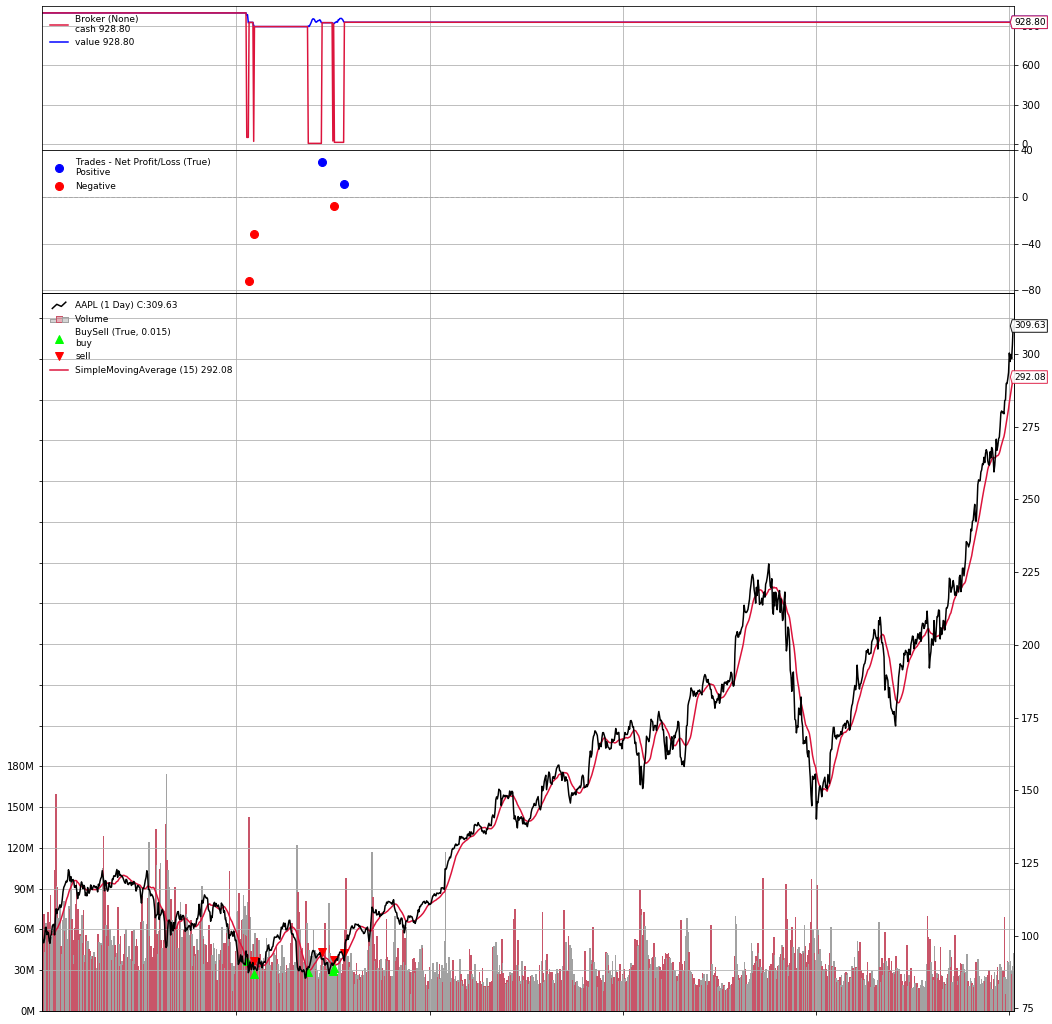

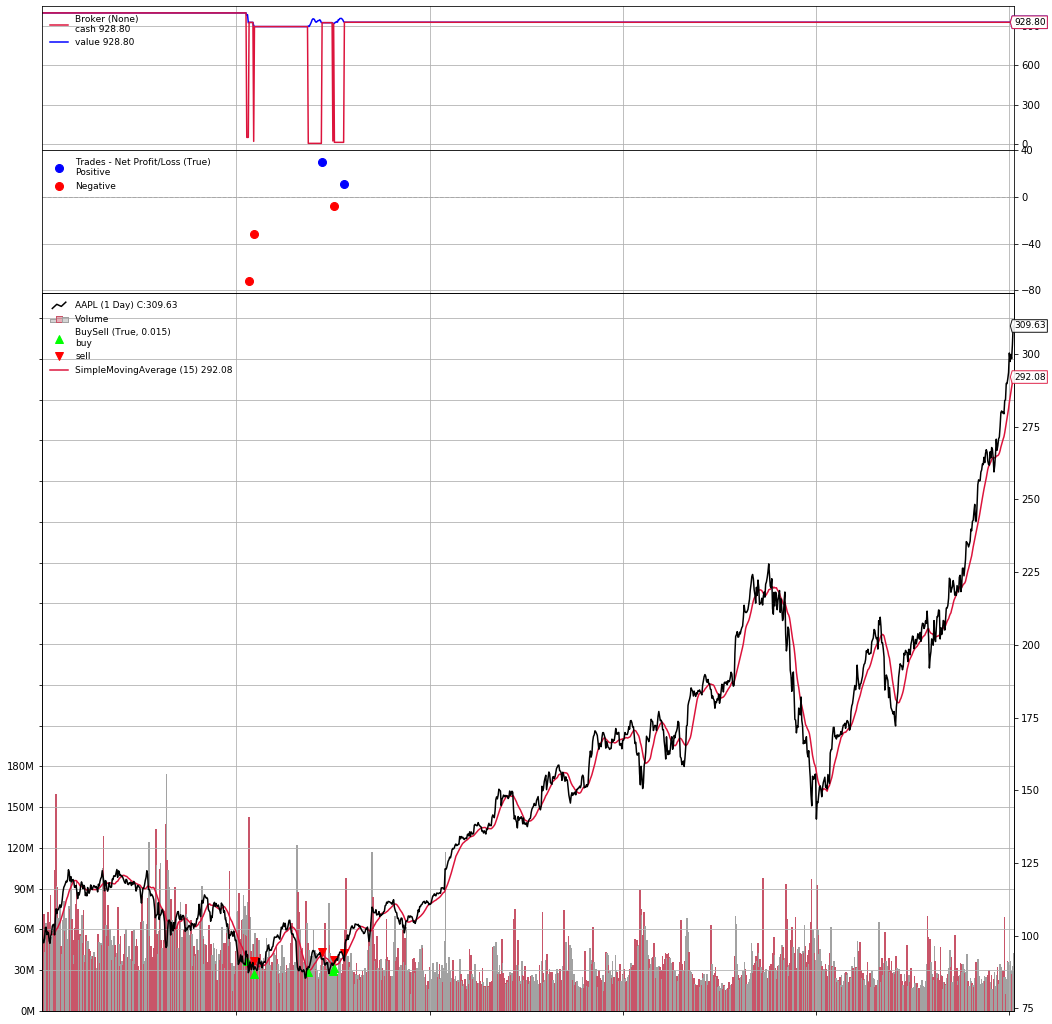

In [87]:
# %%debug
plt.figure(num=0, figsize=(15, 15))
print(cerebro.plot())

cerebro.plot()[0][0]

Being the location for sure after cerebro.run() has been called.

In order to display the automatic plotting capabilities and a couple of easy customizations, the following will be done:

- A 2nd MovingAverage (Exponential) will be added. The defaults will plot it (just like the 1st) with the data.

- A 3rd MovingAverage (Weighted) will be added. Customized to plot in an own plot (even if not sensible)

- A Stochastic (Slow) will be added. No change to the defaults.

- A MACD will be added. No change to the defaults.

- A RSI will be added. No change to the defaults.

- A MovingAverage (Simple) will be applied to the RSI. No change to the defaults (it will be plotted with the RSI)

- An AverageTrueRange will be added. Changed defaults to avoid it being plotted.

The entire set of additions to the init method of the Strategy:

* Even if indicators are not explicitly added to a member variable of the strategy (like self.sma = MovingAverageSimple…), they will autoregister with the strategy and will influence the minimum period for next and will be part of the plotting.

In the example only RSI is added to a temporary variable rsi with the only intention to create a MovingAverageSmoothed on it.

The example now:

In [92]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

Starting Portfolio Value: 1000.00
2015-02-20, Close, 119.46
2015-02-20, BUY CREATE, 119.46
2015-02-23, Order Canceled/Margin/Rejected
2015-02-23, Close, 122.68
2015-02-23, BUY CREATE, 122.68
2015-02-24, Order Canceled/Margin/Rejected
2015-02-24, Close, 121.92
2015-02-24, BUY CREATE, 121.92
2015-02-25, Order Canceled/Margin/Rejected
2015-02-25, Close, 118.80
2015-02-25, BUY CREATE, 118.80
2015-02-26, Order Canceled/Margin/Rejected
2015-02-26, Close, 120.31
2015-02-26, BUY CREATE, 120.31
2015-02-27, Order Canceled/Margin/Rejected
2015-02-27, Close, 118.50
2015-02-27, BUY CREATE, 118.50
2015-03-02, Order Canceled/Margin/Rejected
2015-03-02, Close, 119.08
2015-03-02, BUY CREATE, 119.08
2015-03-03, Order Canceled/Margin/Rejected
2015-03-03, Close, 119.33
2015-03-03, BUY CREATE, 119.33
2015-03-04, Order Canceled/Margin/Rejected
2015-03-04, Close, 118.57
2015-03-05, Close, 116.61
2015-03-06, Close, 116.78
2015-03-09, Close, 117.28
2015-03-10, Close, 114.85
2015-03-11, Close, 112.76
2015-03-12

<IPython.core.display.Javascript object>

0
<class 'matplotlib.figure.Figure'>


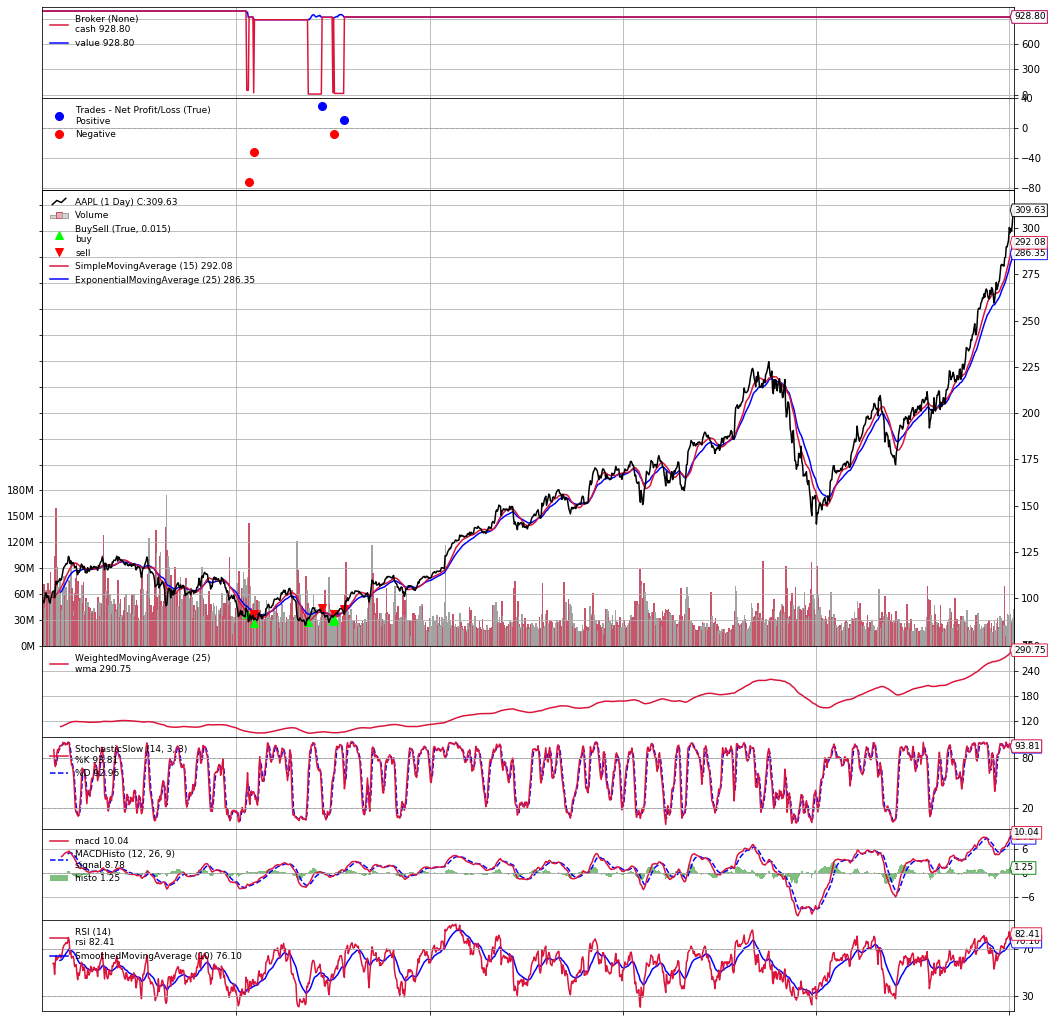

In [95]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    datapath = os.path.join(os.getcwd(), './AAPL.csv')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2015, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2020, 1, 10),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    plt.figure(num=0, figsize=(15, 15))
    cerebro.plot()[0][0]
#     plt.show()
    print(cerebro.plot()[0][0].number)
    print(type(cerebro.plot()[0][0]))

## Let’s Optimize

Many trading books say each market and each traded stock (or commodity or ..) have different rythms. That there is no such thing as a one size fits all.

Before the plotting sample, when the strategy started using an indicator the period default value was 15 bars. It’s a strategy parameter and this can be used in an optimization to change the value of the parameter and see which one better fits the market.

parameter optimizing 해주는 것. 오버피팅 되지 않도록 주의해야. test set에 너무 최적화되면 안된다. 

There is plenty of literature about Optimization and associated pros and cons. But the advice will always point in the same direction: do not overoptimize. If a trading idea is not sound, optimizing may end producing a positive result which is only valid for the backtested dataset.

The sample is modified to optimize the period of the Simple Moving Average. For the sake of clarity any output with regards to Buy/Sell orders has been removed

The example now:

In [90]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)

Instead of calling addstrategy to add a stratey class to Cerebro, the call is made to optstrategy. And instead of passing a value a range of values is passed.

One of the “Strategy” hooks is added, the stop method, which will be called when the data has been exhausted and backtesting is over. It’s used to print the final net value of the portfolio in the broker (it was done in Cerebro previously)

The system will execute the strategy for each value of the range. The following will be output:

In [91]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.optstrategy( # 최적화 
        TestStrategy,
        maperiod=range(10, 31))

    datapath = os.path.join(os.getcwd(), './AAPL.csv')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2015, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2020, 1, 10),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Run over everything
    cerebro.run(maxcpus=1)

2020-01-09, (MA Period 10) Ending Value 886.10
2020-01-09, (MA Period 11) Ending Value 941.10
2020-01-09, (MA Period 12) Ending Value 947.70
2020-01-09, (MA Period 13) Ending Value 937.30
2020-01-09, (MA Period 14) Ending Value 937.30
2020-01-09, (MA Period 15) Ending Value 928.80
2020-01-09, (MA Period 16) Ending Value 924.30
2020-01-09, (MA Period 17) Ending Value 1494.30
2020-01-09, (MA Period 18) Ending Value 2226.90
2020-01-09, (MA Period 19) Ending Value 3211.90
2020-01-09, (MA Period 20) Ending Value 3345.60
2020-01-09, (MA Period 21) Ending Value 3346.40
2020-01-09, (MA Period 22) Ending Value 3534.90
2020-01-09, (MA Period 23) Ending Value 3550.10
2020-01-09, (MA Period 24) Ending Value 3550.50
2020-01-09, (MA Period 25) Ending Value 2635.30
2020-01-09, (MA Period 26) Ending Value 2067.30
2020-01-09, (MA Period 27) Ending Value 2057.90
2020-01-09, (MA Period 28) Ending Value 3098.00
2020-01-09, (MA Period 29) Ending Value 2049.60
2020-01-09, (MA Period 30) Ending Value 2038.60

## Conclusion

The incremental samples have shown how to go from a barebones script to a fully working trading system which even plots the results and can be optimized.

A lot more can be done to try to improve the chances of winning:

Self defined Indicators

Creating an indicator is easy (and even plotting them is easy)

Sizers

Money Management is for many the key to success

Order Types (limit, stop, stoplimit)

Some others

To ensure all the above items can be fully utilized the documentation provides an insight into them (and other topics)

Look in the table of contents and keep on reading … and developing.

Best of luck